In [75]:
# University of New Mexico
# Authors: Jered Dominguez-Trujillo and Sahba Tashakkori
# Date: May 5, 2020
# Description: Script to Analyze DB Data

# Import Statements
import pandas as pd
import numpy as np
import os
import urllib.request, json
import sys
from matplotlib import pyplot as plt
from datetime import date
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures
import matplotlib

In [21]:
def StateDailyCases(pathToCSV, States=None):
    df = pd.read_csv(pathToCSV)

    if States == None:
        States = df['STATE'].unique()

    _, axs = plt.subplots(2, 2, figsize=(15, 15))

    for State in States:
        Statedf = df[df['STATE'] == State]
        Statedf = Statedf.sort_values(by=['DATERECORDED'])
        
        #calculating the diff of successive cumulative values to get per day data
        Positive = [Statedf['POSITIVE'].iloc[ii] - Statedf['POSITIVE'].iloc[ii - 1] for ii in range(1, len(Statedf['POSITIVE']))]
        Negative = [Statedf['NEGATIVE'].iloc[ii] - Statedf['NEGATIVE'].iloc[ii - 1] for ii in range(1, len(Statedf['NEGATIVE']))]
        Total = [Statedf['TOTAL'].iloc[ii] - Statedf['TOTAL'].iloc[ii - 1] for ii in range(1, len(Statedf['TOTAL']))]
        Death = [Statedf['DEATH'].iloc[ii] - Statedf['DEATH'].iloc[ii - 1] for ii in range(1, len(Statedf['DEATH']))]

        axs[0, 0].plot(list(range(1, len(Statedf))), Positive, '-o', label=State)
        axs[0, 1].plot(list(range(1, len(Statedf))), Negative, '-o', label=State)
        axs[1, 0].plot(list(range(1, len(Statedf))), Total, '-o', label=State)
        axs[1, 1].plot(list(range(1, len(Statedf))), Death, '-o', label=State)

    axs[0, 0].legend(loc='upper right')
    axs[0, 1].legend(loc='upper right')
    axs[1, 0].legend(loc='upper right')
    axs[1, 1].legend(loc='upper right')

    axs[0, 0].set_title('Daily Positive Tests')
    axs[0, 1].set_title('Daily Negative Tests')
    axs[1, 0].set_title('Daily Total Tests')
    axs[1, 1].set_title('Daily Deaths')

In [25]:
def StateTotalCases(pathToCSV, States=None):
    df = pd.read_csv(pathToCSV)

    if States == None:
        States = df['STATE'].unique()

    _, axs = plt.subplots(2, 2, figsize=(15, 15))

    for State in States:
        Statedf = df[df['STATE'] == State]
        #although dates are interpreted as string, we can sort them as is
        Statedf = Statedf.sort_values(by=['DATERECORDED'])

        axs[0, 0].plot(list(range(0, len(Statedf))), Statedf['POSITIVE'], '-o', label=State)
        axs[0, 1].plot(list(range(0, len(Statedf))), Statedf['NEGATIVE'], '-o', label=State)
        axs[1, 0].plot(list(range(0, len(Statedf))), Statedf['TOTAL'], '-o', label=State)
        axs[1, 1].plot(list(range(0, len(Statedf))), Statedf['DEATH'], '-o', label=State)

    axs[0, 0].legend(loc='upper right')
    axs[0, 1].legend(loc='upper right')
    axs[1, 0].legend(loc='upper right')
    axs[1, 1].legend(loc='upper right')

    axs[0, 0].set_title('Total Positive Tests')
    axs[0, 1].set_title('Total Negative Tests')
    axs[1, 0].set_title('Total Total Tests')
    axs[1, 1].set_title('Total Deaths')

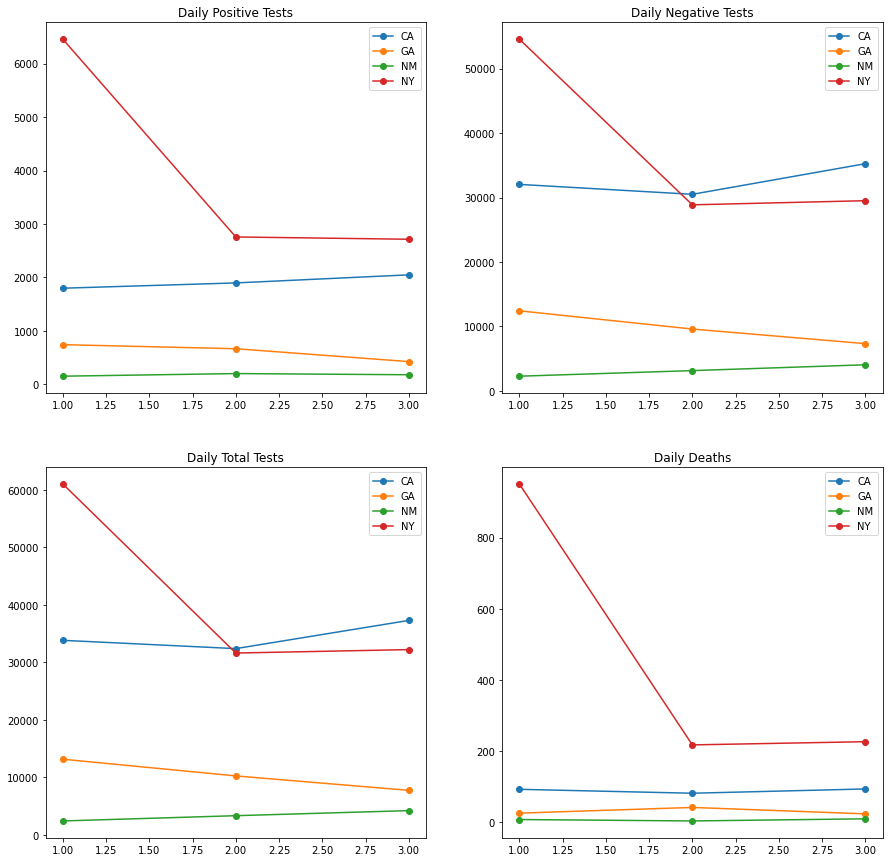

In [23]:
StateDailyCases('./AnalysisData/Q1_CASES_EXPORT.csv', ['CA', 'GA', 'NM', 'NY'])

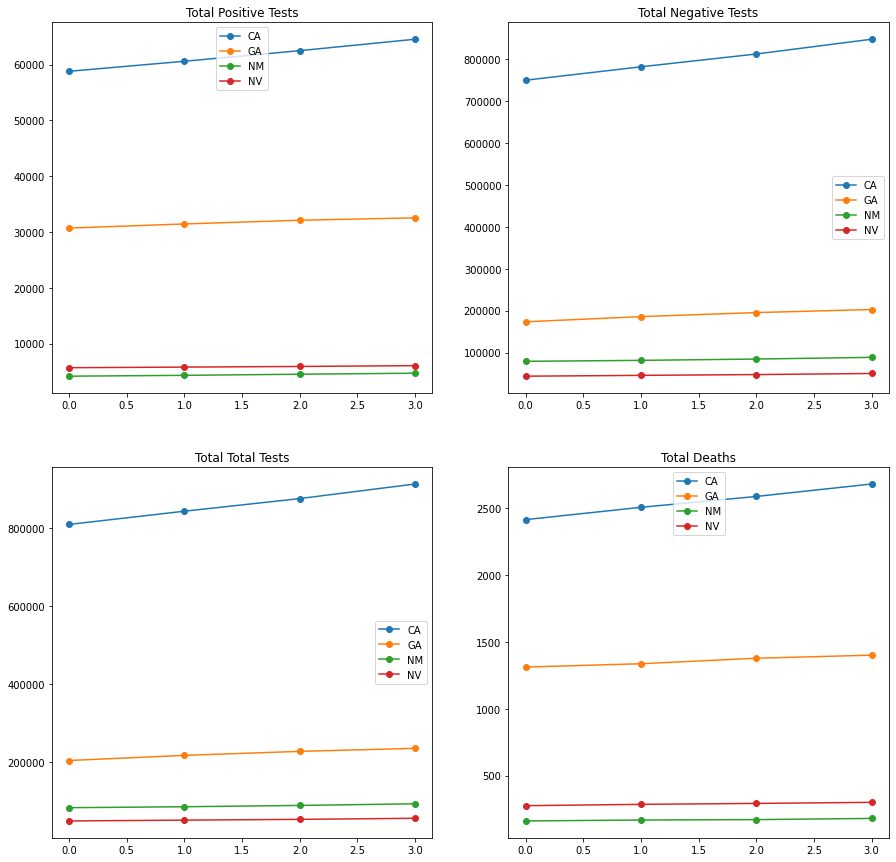

In [26]:
StateTotalCases('./AnalysisData/Q1_CASES_EXPORT.csv', ['CA', 'GA', 'NM', 'NV'])

## Analyzing medical aid and test data

#### Giving the double axis a try

DATERECORDED STATE  POSITIVE  NEGATIVE  TEST_TOTAL  DEATH  \
0  2020-06-05 00:00:00    AK       372   23283.0       23655     10   
1  2020-07-05 00:00:00    AK       374   23967.0       24341     10   
2  2020-06-05 00:00:00    AL      8581  100935.0      109516    340   
3  2020-07-05 00:00:00    AL      8898  106275.0      115173    349   
4  2020-06-05 00:00:00    AR      3568   55435.0       59003     85   

   DELIVERIES     COST  WEIGHT  
0           1  1095.85     210  
1           1  1095.85     210  
2          13  5366.07     970  
3          15  7557.77    1390  
4          11  4161.43     735  
           DATERECORDED STATE  POSITIVE  NEGATIVE  TEST_TOTAL  DEATH  \
64  2020-06-05 00:00:00    NM      4138   79113.0       83251    162   
65  2020-07-05 00:00:00    NM      4291   81393.0       85684    169   

    DELIVERIES     COST  WEIGHT  
64           2   218.04      65  
65           3  1313.89     275  
           DATERECORDED STATE  POSITIVE  NEGATIVE  TEST_TOTAL  DEA

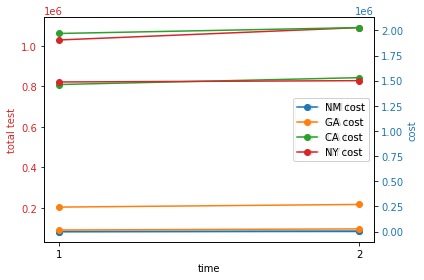

In [15]:

csv_path="./AnalysisData/medaid_and_test.csv"
df = pd.read_csv(csv_path)
print(df.head())
state_list = 'NM GA CA NY'.split()
fig, ax1 = plt.subplots()
ax1.set_xlabel('time')
color = 'tab:red'
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('total test', color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cost', color=color)
ax2.tick_params(axis='y', labelcolor=color)

for state in state_list:
    state_df= df[df['STATE'] == state]
    print(state_df.head())
    x_range = list(range(1, len(state_df) + 1))
    ax1.plot(x_range, state_df['TEST_TOTAL'], '-o', label=F"{state} test")
    # we already handled the x-label with ax1
    ax2.plot(x_range, state_df['COST'], '-o', label=F"{state} cost")
ax1.legend()
ax2.legend()
plt.xticks(ticks= x_range)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

The score is 0.16 and the parames are  [0.04778521]


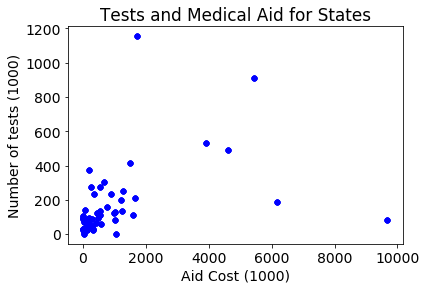

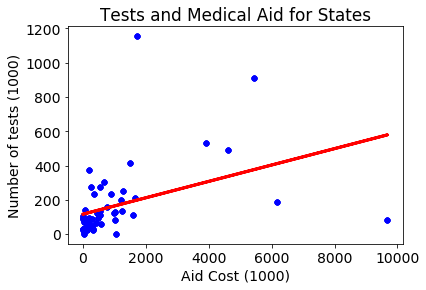

In [87]:
csv_path="./AnalysisData/Q2_MEDAID_EXPORT.csv"
df = pd.read_csv(csv_path)
state_list = 'NM GA CA NY'.split()
matplotlib.rcParams.update({'font.size': 14})

def plot_test_cost():
    _=plt.figure()
    costs=[]
    tests=[]
    for state in df.STATE:
    # for state in state_list:
        state_df= df[df['STATE'] == state]
        state_df = state_df.sort_values(by=['DATERECORDED']).iloc[-1]
        state_cost = state_df['COST']/1000
        state_test = state_df['TEST_TOTAL']/1000
        costs.append(state_cost)
        tests.append(state_test)
        plt.plot(state_cost, state_test,"ob", markersize=5, label=state)
    plt.xlabel("Aid Cost (1000)")
    plt.ylabel("Number of tests (1000)")
    plt.title("Tests and Medical Aid for States")
    return costs, tests
plot_test_cost()
costs, tests = plot_test_cost()
costs_reshaped = np.array(costs).reshape((len(costs),1))
reg = LR().fit(costs_reshaped, tests)
print("The score is %.2f and the parames are " % reg.score(costs_reshaped, tests), reg.coef_)
y_fit = reg.predict(costs_reshaped)
_ = plt.plot(costs, y_fit, '-r', linewidth=3)
plt.savefig("diagrams/test_cost_fit.png", bbox_inches='tight', pad_inches=0.3)
plt.show() 


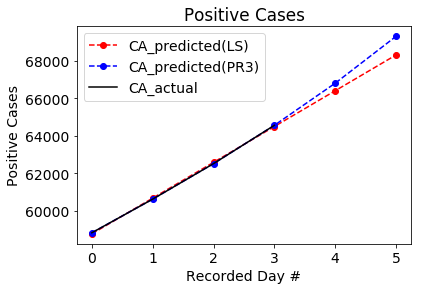

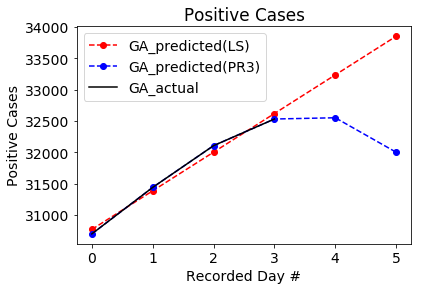

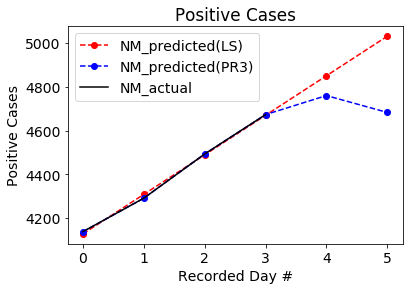

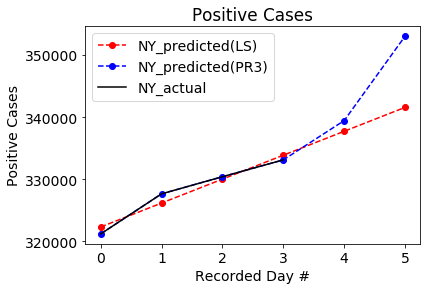

In [95]:
#Start with linead Regression
#SVR did not work debug later
# from sklearn import svm
csv_path="./AnalysisData/Q1_CASES_EXPORT.csv"
df = pd.read_csv(csv_path)
feature_point_count = 2
matplotlib.rcParams.update({'font.size': 14})

for state in ['CA', 'GA', 'NM', 'NY']:
    state_df = df[df.STATE==state]
    state_df = state_df.sort_values(by=['DATERECORDED'])
    time_values = np.array(list(range(len(state_df))))
    positive_results = state_df['POSITIVE']
    reshaped_x = time_values.reshape(len(time_values),1)
    reg = LR().fit(reshaped_x, positive_results)
    poly_features = PolynomialFeatures(degree=3)
    X_poly = poly_features.fit_transform(reshaped_x)
    poly_reg = LR().fit(X_poly, positive_results)
    future_time_values = np.concatenate((time_values,
                                        np.arange(len(time_values), len(time_values) + feature_point_count)))
    future_x_reshaped = future_time_values.reshape(len(future_time_values),1)
    predicted_pos_ls = reg.predict(future_x_reshaped)
    
    predicted_pos_pr = poly_reg.predict(poly_features.fit_transform(future_x_reshaped))
    plt.figure()
    plt.title('Positive Cases')
    plt.plot(future_time_values, predicted_pos_ls, "--or", label=state + "_predicted(LS)" )    
    plt.plot(future_time_values, predicted_pos_pr, "--ob", label=state + "_predicted(PR3)" )    
    plt.plot(time_values, state_df.POSITIVE,"-k", label=state + "_actual" )
    plt.xlabel("Recorded Day #")
    plt.ylabel("Positive Cases")
    plt.legend()
    plt.savefig(F"diagrams/positive_trend_{state}.png", bbox_inches='tight', pad_inches=0.3)
    

Text(0, 0.5, 'death per capita')

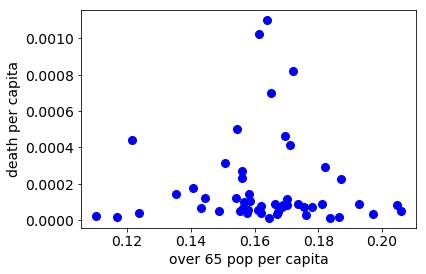

In [102]:
#Start with linead Regression
#SVR did not work debug later
# from sklearn import svm
csv_path="./AnalysisData/death_pop.csv"
df = pd.read_csv(csv_path)
matplotlib.rcParams.update({'font.size': 14})
_=plt.figure()
for state in df['STATE'].unique():
    state_df = df[df.STATE==state]
    death_rate_norm = state_df['DEATH']/state_df['TOTAL_POP']
    over65_rate_norm = state_df['OVER65POP']/state_df['TOTAL_POP']
    plt.plot(over65_rate_norm, death_rate_norm,"ob", markersize=8, label=state)
plt.xlabel('over 65 pop per capita')
plt.ylabel('death per capita')
    